In [1]:
import pandas as pd
import re
import string
import numpy as np
from collections import Counter
import pickle
from gensim.parsing.preprocessing import preprocess_string
from pyemd import emd
from gensim.models import FastText
from tqdm import tqdm
from IPython.display import clear_output
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from IPython.display import clear_output
from torch.optim import Adam
from torch.optim import Optimizer
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.metrics import roc_auc_score

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [22]:
POSTGRES_USER = os.environ.get("POSTGRES_USER")
POSTGRES_PASSWORD = os.environ.get("POSTGRES_PASSWORD")
POSTGRES_HOST = os.environ.get("POSTGRES_HOST")
POSTGRES_PORT = os.environ.get("POSTGRES_PORT")
POSTGRES_DATABASE = os.environ.get("POSTGRES_DATABASE")

In [23]:
# Датасет по постам
posts_info = pd.read_sql(
    """SELECT * FROM public.post_text_df""",
    
    con="postgresql://" + POSTGRES_USER + ":" + POSTGRES_PASSWORD + "@"
        + str(POSTGRES_HOST) + ":" + POSTGRES_PORT + "/" + POSTGRES_DATABASE)

posts_info.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [24]:
# Датасет по юзерам
user_info = pd.read_sql(
    """SELECT * FROM public.user_data""",
    
    con="postgresql://" + POSTGRES_USER + ":" + POSTGRES_PASSWORD + "@"
        + str(POSTGRES_HOST) + ":" + POSTGRES_PORT + "/" + POSTGRES_DATABASE)

user_info.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


### Юзер фичи

In [6]:
cat_cols_user = ['gender', 'country', 'city', 'exp_group', 'os', 'source']

In [25]:
user_info.city.nunique()

3915

In [7]:
# Обработка категориальных фичей
from sklearn.preprocessing import OrdinalEncoder
for col in cat_cols_user:
    if user_info[col].nunique() <= 7:
        one_hot = pd.get_dummies(user_info[col], prefix=col, drop_first=True)
        user_info = pd.concat((user_info.drop(col, axis=1), one_hot), axis=1)

    elif user_info[col].nunique() > 7:
        ord_enc = OrdinalEncoder()
        user_info[f"code_{col}"] = ord_enc.fit_transform(user_info[[col]])
        user_info = user_info.drop(col, axis=1)


In [8]:
user_info

,user_id,age,gender_1,code_country,code_city,exp_group_1,exp_group_2,exp_group_3,exp_group_4,os_iOS,source_organic
0,200,34,1,7.0,651.0,0,0,1,0,0,0
1,201,37,0,7.0,2.0,0,0,0,0,0,0
2,202,17,1,7.0,2931.0,0,0,0,1,0,0
3,203,18,0,7.0,1953.0,1,0,0,0,1,0
4,204,36,0,7.0,125.0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
163200,168548,36,0,7.0,1124.0,0,0,0,1,0,1
163201,168549,18,0,7.0,3287.0,0,1,0,0,0,1
163202,168550,41,1,7.0,3698.0,0,0,0,1,0,1
163203,168551,38,0,7.0,1953.0,0,0,1,0,1,1


In [9]:
# Пролайканные посты

def load_data_sql(query: str):
    engine = create_engine(
        "postgresql://" + POSTGRES_USER + ":" + POSTGRES_PASSWORD + "@"
        + str(POSTGRES_HOST) + ":" + POSTGRES_PORT + "/" + POSTGRES_DATABASE)
    conn = engine.connect().execution_options(stream_results=True)
    parts = []

    for part in pd.read_sql(query, conn, chunksize=150000):
        parts.append(part)
    conn.close()
    return pd.concat(parts, ignore_index=True)

like_post_q = """
        SELECT distinct post_id, user_id
        FROM public.feed_data
        where action='like'"""
liked_posts = load_data_sql(like_post_q)

In [10]:
#Cоздание векторов пользователей, по предпочтениям тем (лайки)

df_vec_users_like = pd.DataFrame()
list_of_user_id =  user_info.user_id.values
for uid in tqdm(list_of_user_id):
    L_U = liked_posts[liked_posts.user_id == uid]
    df_vu = pd.merge(L_U, posts_info[['post_id','topic']], on='post_id', how='left')
    vecs = pd.DataFrame(round(df_vu[['topic']].value_counts()/len(df_vu), 3)).T
    vecs['user_id'] = uid
    df_vec_users_like = pd.concat((df_vec_users_like,vecs),axis=0)
    
df_vec_users_like = df_vec_users_like.rename(columns={'movie': 'u_vl_movie', 'covid':'u_vl_covid', 'sport':'u_vl_sport',
                                                      'entertainment':'u_vl_entertainment', 'politics':'u_vl_politics', 
                                                     'business':'u_vl_business', 'tech':'u_vl_tech'})

100%|██████████████████████████████████████████████████████████████████████████| 163205/163205 [59:11<00:00, 45.96it/s]


In [ ]:
user_info = pd.merge(user_info, df_vec_users_like, on='user_id', how='left')

user_info.to_csv('A_features_users.csv', index=False)

https://drive.google.com/file/d/1qvpO9z-kPrYMCqbt-wdsDJcs0BAru9A8/view?usp=sharing

In [12]:
user_info

,user_id,age,gender_1,code_country,code_city,exp_group_1,exp_group_2,exp_group_3,exp_group_4,os_iOS,source_organic,u_vl_movie,u_vl_covid,u_vl_sport,u_vl_entertainment,u_vl_politics,u_vl_business,u_vl_tech
0,200,34,1,7.0,651.0,0,0,1,0,0,0,0.349,0.209,0.163,0.093,0.093,0.047,0.047
1,201,37,0,7.0,2.0,0,0,0,0,0,0,0.569,0.190,0.034,0.069,0.017,0.052,0.069
2,202,17,1,7.0,2931.0,0,0,0,1,0,0,0.402,0.253,0.149,0.011,0.172,0.011,0.000
3,203,18,0,7.0,1953.0,1,0,0,0,1,0,0.410,0.213,0.180,0.033,0.082,0.049,0.033
4,204,36,0,7.0,125.0,0,0,1,0,0,0,0.391,0.348,0.087,0.043,0.043,0.043,0.043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,168548,36,0,7.0,1124.0,0,0,0,1,0,1,0.350,0.300,0.000,0.100,0.050,0.050,0.150
163201,168549,18,0,7.0,3287.0,0,1,0,0,0,1,0.273,0.227,0.182,0.000,0.318,0.000,0.000
163202,168550,41,1,7.0,3698.0,0,0,0,1,0,1,0.579,0.263,0.026,0.053,0.000,0.026,0.053
163203,168551,38,0,7.0,1953.0,0,0,1,0,1,1,0.447,0.340,0.085,0.064,0.021,0.021,0.021


### Фичи по постам

In [13]:
# Функции убирающие ссылки, эмодзи и смайлики
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001F912-\U0001F923"
                           u"\U0001F9A0"
                           u"\U0001F9D0"
                           u"\U0001FA78"
                           u"\U0001F9FC"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

with open('Emoticon_Dict.p', 'rb') as fp:
    Emoticon_Dict = pickle.load(fp)

def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in Emoticon_Dict) + u')')
    return emoticon_pattern.sub(r'', text)

In [14]:
posts_info['text'] = posts_info['text'].apply(remove_urls).apply(remove_emoji).apply(remove_emoticons).apply(preprocess_string)
posts_info.head()


,post_id,text,topic
0,1,"[economi, face, major, risk, manufactur, secto...",business
1,2,"[aid, climat, davo, agenda, climat, chang, fig...",business
2,3,"[asian, quak, hit, european, share, share, eur...",business
3,4,"[india, power, share, jump, debut, share, indi...",business
4,5,"[lacroix, label, bought, firm, luxuri, good, g...",business


In [15]:
# Обучаем Fasttext на всех текстах постов
vec_size = 80
model_FT = FastText(vector_size=vec_size, window=10, min_count=1, workers=8, sg=1)
model_FT.build_vocab(corpus_iterable=posts_info.text)
model_FT.train(corpus_iterable=posts_info.text, total_examples=len(posts_info.text), epochs=10)

(7346217, 7527540)

In [16]:
# Создеаем векторное представление постов
cols = []
for i in range(vec_size):
    cols.append(f'Vec_text_{i}')
    
for j in range(len(posts_info.text)):
    for i in range(len(posts_info.text[j])):
        if i == 0:
            first = model_FT.wv.get_vector(posts_info.text[j][i], norm=False)
        else:
            sec = model_FT.wv.get_vector(posts_info.text[j][i], norm=False)
            first = first + sec
    if j == 0:
        x = pd.DataFrame(first.reshape(1, -1))
    else:
        y = pd.DataFrame(first.reshape(1, -1))
        x = pd.concat((x,y),axis=0)

Vec_of_text = x.set_axis(cols, axis=1, inplace=False).reset_index().drop('index',axis=1)

In [17]:
posts_info = pd.concat((posts_info, Vec_of_text),axis=1).drop('text', axis=1)

In [18]:
# Что лайкают больше
top_of_posts = pd.read_sql(
        """SELECT f.post_id, COUNT(f.post_id)
        FROM feed_action f
        WHERE f.action = 'like'
        GROUP BY f.post_id
        ORDER BY COUNT(f.post_id) DESC""",

        con="postgresql://" + POSTGRES_USER + ":" + POSTGRES_PASSWORD + "@"
        + str(POSTGRES_HOST) + ":" + POSTGRES_PORT + "/" + POSTGRES_DATABASE)

In [19]:
posts_info = pd.merge(posts_info, top_of_posts, on='post_id', how='left')


In [20]:
posts_info = posts_info.fillna(0)

In [21]:
one_hot = pd.get_dummies(posts_info['topic'], prefix='topic', drop_first=True)
posts_info = pd.concat((posts_info.drop('topic', axis=1), one_hot), axis=1)

posts_info.round(3).to_csv('A_features_posts.csv', index=False)

https://drive.google.com/file/d/1dl5cFOrXh1C6MlNSAhAoj5sOnlVRkIvF/view?usp=sharing

In [22]:
posts_info

,post_id,Vec_text_0,Vec_text_1,Vec_text_2,Vec_text_3,Vec_text_4,Vec_text_5,Vec_text_6,Vec_text_7,Vec_text_8,...,Vec_text_77,Vec_text_78,Vec_text_79,count,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
0,1,87.766,20.662,-36.691,54.717,23.386,33.048,78.325,62.458,-9.297,...,-3.404,108.093,51.722,160.0,0,0,0,0,0,0
1,2,149.636,26.142,15.669,36.574,19.599,52.482,65.318,84.862,-20.980,...,-9.504,138.243,17.951,3.0,0,0,0,0,0,0
2,3,155.913,38.147,-42.053,109.291,18.257,49.829,91.294,113.674,1.392,...,-29.664,200.575,83.684,257.0,0,0,0,0,0,0
3,4,57.984,21.350,-19.699,25.228,11.420,16.817,16.417,46.737,-2.478,...,-4.273,62.296,35.713,849.0,0,0,0,0,0,0
4,5,61.760,16.212,-10.093,20.166,22.286,8.268,18.892,26.645,-1.932,...,6.793,43.368,3.832,6.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7315,28.210,-2.129,2.509,22.790,5.948,1.768,14.273,5.207,1.158,...,-5.950,29.843,-6.882,1051.0,0,0,1,0,0,0
7019,7316,25.791,-7.369,-0.869,21.724,8.283,4.446,16.568,6.675,-4.316,...,-2.840,33.790,-2.509,205.0,0,0,1,0,0,0
7020,7317,22.255,-7.332,-1.487,15.902,4.051,6.223,11.315,4.534,-3.714,...,-2.914,28.138,-5.039,175.0,0,0,1,0,0,0
7021,7318,24.803,-3.590,2.517,17.639,3.824,4.156,14.896,3.095,1.002,...,-2.321,29.899,-4.422,301.0,0,0,1,0,0,0


### Создание train/test выборок

In [ ]:
feed_data = pd.read_sql(
    """SELECT * FROM public.feed_data LIMIT 10000000""",
    
    con="postgresql://" + POSTGRES_USER + ":" + POSTGRES_PASSWORD + "@"
        + str(POSTGRES_HOST) + ":" + POSTGRES_PORT + "/" + POSTGRES_DATABASE)

feed_data = feed_data[feed_data.action=='view'].drop('action', axis=1)
feed_data.head()

In [ ]:
feed_data

In [ ]:
feed_data = feed_data.reset_index(drop=True)

In [ ]:
feed_data['hour'] = pd.to_datetime(feed_data['timestamp']).apply(lambda x: x.hour)
feed_data['month'] = pd.to_datetime(feed_data['timestamp']).apply(lambda x: x.month)
feed_data['day'] = pd.to_datetime(feed_data['timestamp']).apply(lambda x: x.day)

In [ ]:
# Приходится разбивать на части, так как много оперативы требуется
x = 1786215
for i in tqdm(range(5)):
    df = feed_data[0 + x * i : x + x * i]
    df = pd.merge(df, posts_info, on='post_id', how='left')#.drop('post_id',axis=1)   
    df = pd.merge(df, user_info, on='user_id', how='left')#.drop(['user_id'],axis=1)
    df = df.set_index(['user_id', 'post_id'])
    df[df.timestamp < '2021-12-15'].drop('timestamp', axis=1).drop('target', axis=1).to_csv(f'X_train_p{i+1}.csv', index=False)
    df[df.timestamp < '2021-12-15'].drop('timestamp', axis=1)['target'].to_csv(f'y_train_p{i+1}.csv', index=False)
    df[df.timestamp >= '2021-12-15'].drop('timestamp', axis=1).drop('target', axis=1).to_csv(f'X_test_p{i+1}.csv', index=False)
    df[df.timestamp >= '2021-12-15'].drop('timestamp', axis=1)['target'].to_csv(f'y_test_p{i+1}.csv', index=False)

## Обучение модели

In [2]:
def train(model, train_loader, optimizer, loss_fn, device):
    model.train()

    train_loss = 0
    roc_auc_train = 0
    
    for x, y in tqdm(train_loader, desc='Train'):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        
        output = model(x)
        loss = loss_fn(output, y)

        train_loss += loss.item()
        roc_auc_train += roc_auc_score(y.detach().cpu().numpy(), output.detach().cpu().numpy())    
        
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    roc_auc_train /= len(train_loader)
    
    return train_loss,  roc_auc_train

In [3]:
@torch.inference_mode()
def evaluate(model, valid_loader, loss_fn, device):
    model.eval()

    total_loss = 0
    roc_auc_valid = 0
    
    for x, y in tqdm(valid_loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)
        loss = loss_fn(output, y)

        total_loss += loss.item()
        roc_auc_valid += roc_auc_score(y.detach().cpu().numpy(), output.detach().cpu().numpy())
        
    total_loss /= len(valid_loader)
    roc_auc_valid /= len(valid_loader)
    return total_loss, roc_auc_valid

In [4]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    roc_auc_train,
    roc_auc_valid,
    title: str,
):
    plt.figure(figsize=(16, 8))

    plt.title(title + " loss")

    plt.plot(train_loss, label="Train loss")
    plt.plot(valid_loss, label="Valid loss")
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + " ROC_AUC")

    plt.plot(roc_auc_train, label="Train ROC_AUC accuracy")
    plt.plot(roc_auc_valid, label="Valid ROC_AUC accuracy")
    plt.legend()
    plt.grid()

    plt.show()

In [5]:
class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.layer_1 = nn.Sequential(
            nn.Linear(107, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256)
        )
        self.layer_2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256)
        )
        self.layer_3 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256)
        )
        self.layer_out = nn.Linear(256, 1)
                
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_out(x)
        return x

In [6]:
X_train_t = torch.tensor(pd.read_csv('X_train_p1.csv').values, dtype=torch.float32)
X_test_t = torch.tensor(pd.read_csv('X_test_p1.csv').values, dtype=torch.float32)
y_train_t = torch.tensor(pd.read_csv('y_train_p1.csv').values, dtype=torch.float32)
y_test_t = torch.tensor(pd.read_csv('y_test_p1.csv').values, dtype=torch.float32)
for i in tqdm(range(2, 6)):
    X_train_t = torch.cat((X_train_t, torch.tensor(pd.read_csv(f'X_train_p{i}.csv').values, dtype=torch.float32)), 0)
    X_test_t = torch.cat((X_test_t, torch.tensor(pd.read_csv(f'X_test_p{i}.csv').values, dtype=torch.float32)), 0)
    y_train_t = torch.cat((y_train_t, torch.tensor(pd.read_csv(f'y_train_p{i}.csv').values, dtype=torch.float32)), 0)
    y_test_t = torch.cat((y_test_t, torch.tensor(pd.read_csv(f'y_test_p{i}.csv').values, dtype=torch.float32)), 0)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:06<00:00, 31.65s/it]


In [7]:
X_train_t.shape[0]+ X_test_t.shape[0] == 8931075

True

In [8]:
X_train_t.shape[1]

107

In [9]:
train_dataset = TensorDataset(X_train_t, y_train_t)
vaid_dataset = TensorDataset(X_test_t, y_test_t)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=False, num_workers=8, pin_memory=True)
valid_loader = DataLoader(vaid_dataset, batch_size=1000, shuffle=False, num_workers=8, pin_memory=True)

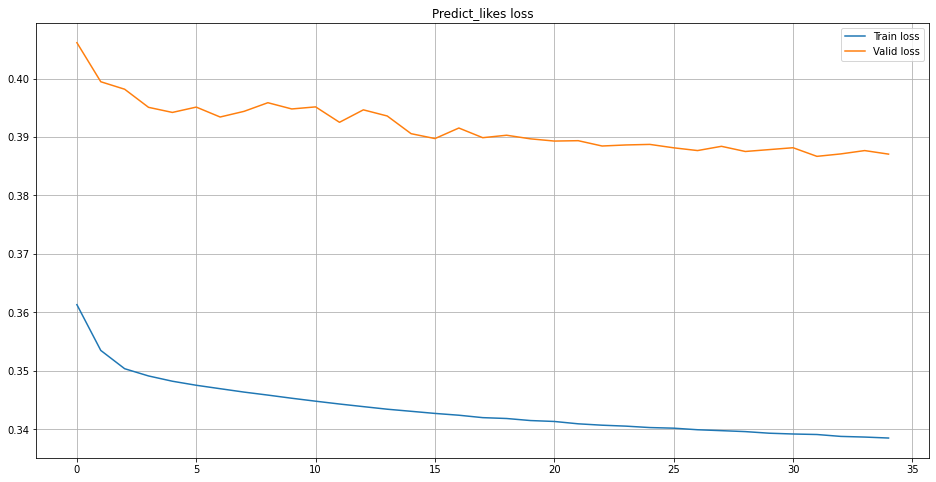

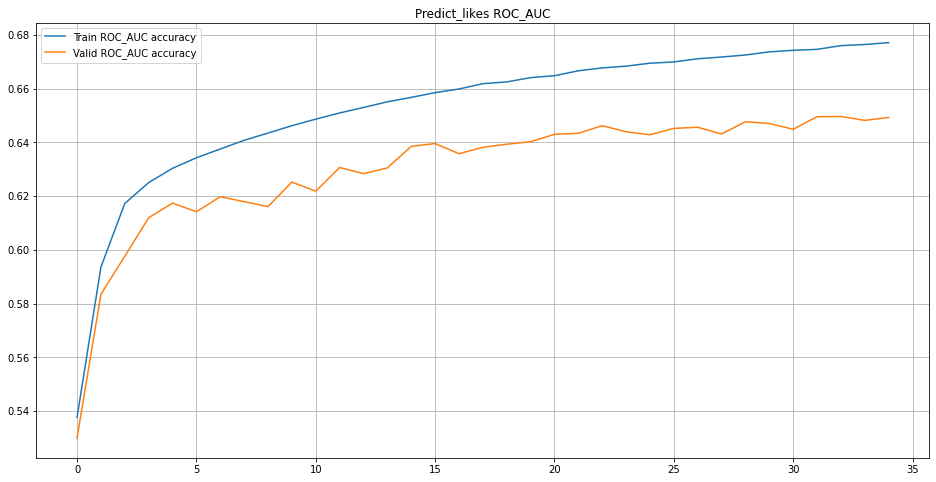

Epoch 35 of 35
Train Loss: 0.33851 Train ROC_AUC: 0.67713
 Test Loss: 0.38707 Test ROC_AUC: 0.64931


In [12]:
## FC_predict 

title = 'Predict_likes'
lr = 0.001
epochs = 35
threshold = 0.7

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = FC().to(device)

optimizer = Adam(model.parameters(), lr=lr)

loss_fn = nn.BCEWithLogitsLoss()

train_loss_history, valid_loss_history = [], []
roc_auc_hist_train, roc_auc_hist_valid = [], []

for epoch in range(epochs):
    train_loss, roc_auc_train = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss, roc_auc_valid = evaluate(model, valid_loader, loss_fn, device)
   
    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    
    roc_auc_hist_train.append(roc_auc_train)
    roc_auc_hist_valid.append(roc_auc_valid)
    
    clear_output(wait=True)

    plot_stats(
        train_loss_history,
        valid_loss_history,
        roc_auc_hist_train,
        roc_auc_hist_valid,
        title,
    )

    print(f'Epoch {epoch+1} of {epochs}')
    print(f'Train Loss: {train_loss:.5f} Train ROC_AUC: {roc_auc_train:.5f}')
    print(f' Test Loss: {valid_loss:.5f} Test ROC_AUC: {roc_auc_valid:.5f}')
    if roc_auc_valid >= threshold:
        break

torch.save(model.state_dict(), "model_test.pt")